# Signal and noise histograms (from simtel files)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

#ctapipe.version.get_version()
print(ctapipe.__version__)
print(pyhessio.__version__)

from ctapipe.instrument import CameraGeometry

# calibrator
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(None, None)

0.5.1
2.0.1


In [2]:
MAX_NUM_SAMPLES = 2000000

## Common functions

In [3]:
def plot_all(simtel_file,
             tel_id_filter_list,
             channel_threshold,
             cam_id,
             max_num_samples=1000000):

    print("Cam ID:", cam_id)
    print("Simtel file:", simtel_file)
    print("Tel ID range:", tel_id_filter_list)

    source = hessio_event_source(simtel_file, allowed_tels=tel_id_filter_list)

    #in_sample_list = []
    sig_sample_list = []
    #noise_sample_list = []
    noise2_sample_list = []
    
    # ITERATE OVER EVENTS #############################################

    for ev in source:

        if (len(sig_sample_list)) > 0 and (len(sig_sample_list) * len(sig_sample_list[0]) >= max_num_samples):
            break
        
        calib.calibrate(ev)  # calibrate the event
        
        # ITERATE OVER IMAGES #########################################

        for tel_id in ev.trig.tels_with_trigger:
            
            if (len(sig_sample_list)) > 0 and (len(sig_sample_list) * len(sig_sample_list[0]) >= max_num_samples):
                break

            tel_id = int(tel_id)

            if tel_id in tel_id_filter_list:

                # CHECK THE IMAGE GEOMETRY ############################

                x, y = ev.inst.pixel_pos[tel_id]
                foclen = ev.inst.optical_foclen[tel_id]
                geom = ctapipe.instrument.CameraGeometry.guess(x, y, foclen)

                if geom.cam_id != cam_id:
                    raise ValueError("Telescope {}: error (the input image is not a valide {} telescope image but a {} telescope image)".format(tel_id, cam_id, geom.cam_id))

                # GET IMAGES ##########################################

                pe_image = ev.mc.tel[tel_id].photo_electron_image  # 1D np array
                #uncalibrated_image = ev.r0.tel[tel_id].adc_sums   # ctapipe 0.4.0
                #pedestal = ev.mc.tel[tel_id].pedestal
                #gain = ev.mc.tel[tel_id].dc_to_pe
                #pixel_pos = ev.inst.pixel_pos[tel_id]
                calibrated_image = ev.dl1.tel[tel_id].image
                
                if channel_threshold is not None:
                    # 2 channels
                    calibrated_image[1, calibrated_image[0,:] <= channel_threshold] = 0
                    calibrated_image[0, calibrated_image[0,:] >  channel_threshold] = 0
                    calibrated_image = calibrated_image.sum(axis=0)
                else:
                    # 1 channel
                    calibrated_image = calibrated_image[0]
                
                # ADD SAMPLES #########################################

                #in_sample_list.append(calibrated_image)
                sig_sample_list.append(pe_image)
                #noise_sample_list.append(calibrated_image - pe_image)
                noise2_sample_list.extend(calibrated_image[pe_image == 0.].tolist())

    #in_sample_array = np.array(in_sample_list).ravel()
    
    sig_sample_array = np.array(sig_sample_list).ravel()
    del sig_sample_list
    
    #noise_sample_array = np.array(noise_sample_list).ravel()
    
    noise2_sample_array = np.array(noise2_sample_list)
    del noise2_sample_list

    # PLOT ############################################################
    
    fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(13, 13))
    
    num_bins = 100
    
    print("Num samples:", len(sig_sample_array))
    print("Memory usage for sig_sample_array: {} Mb".format(sig_sample_array.nbytes / 1000000.))
    print("Memory usage for noise2_sample_array: {} Mb".format(noise2_sample_array.nbytes / 1000000.))
    
    #plt.hist(in_sample_array, bins=num_bins, range=(-10, 2500), log=True);

    ax1.hist(sig_sample_array,
             bins=num_bins,
             range=(-10, 2500),
             log=True)

    #plt.hist(noise_sample_array,
    #         bins=num_bins,
    #         range=(-50, 50),
    #         log=False);

    ax2.hist(noise2_sample_array,
             bins=num_bins,
             #range=(-10, 50),
             log=False)
    
    print("Noise: Mean = {} ; Std = {}".format(noise2_sample_array.mean(), noise2_sample_array.std()))
    print("Min:", noise2_sample_array.min())
    print("Max:", noise2_sample_array.max())

## ASTRI

### INAF's ASTRI mini array

ASTRI = "ASTRICam" (tel 1 to 33 in astri mini array), 2 channels

Cam ID: ASTRICam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Num samples: 2000960
Memory usage for sig_sample_array: 8.00384 Mb
Memory usage for noise2_sample_array: 15.613536 Mb
Noise: Mean = 0.8087130072886098 ; Std = 0.545551299381123
Min: -0.980717163635
Max: 5.03307632302
CPU times: user 1min, sys: 563 ms, total: 1min
Wall time: 1min 2s


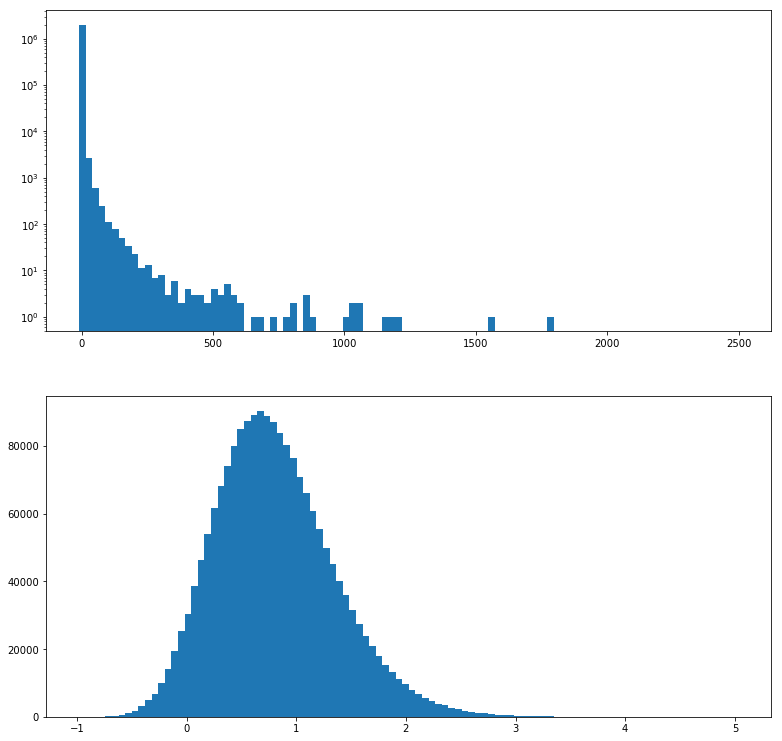

In [4]:
%%time

channel_threshold = 14   # FYI Tino uses 14

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/proton/run10001.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(1, 34)),
         channel_threshold=channel_threshold,
         cam_id="ASTRICam",
         max_num_samples=MAX_NUM_SAMPLES)

### Konrad's ASTRI mini array

ASTRI = "ASTRICam" (tel 1 to 16 in astri mini array), 2 channels

Cam ID: ASTRICam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Num samples: 2000960
Memory usage for sig_sample_array: 8.00384 Mb
Memory usage for noise2_sample_array: 15.564696 Mb
Noise: Mean = 0.8081697829117068 ; Std = 0.5450860456224397
Min: -0.968787836714
Max: 4.7815425046
CPU times: user 1min, sys: 416 ms, total: 1min
Wall time: 1min 1s


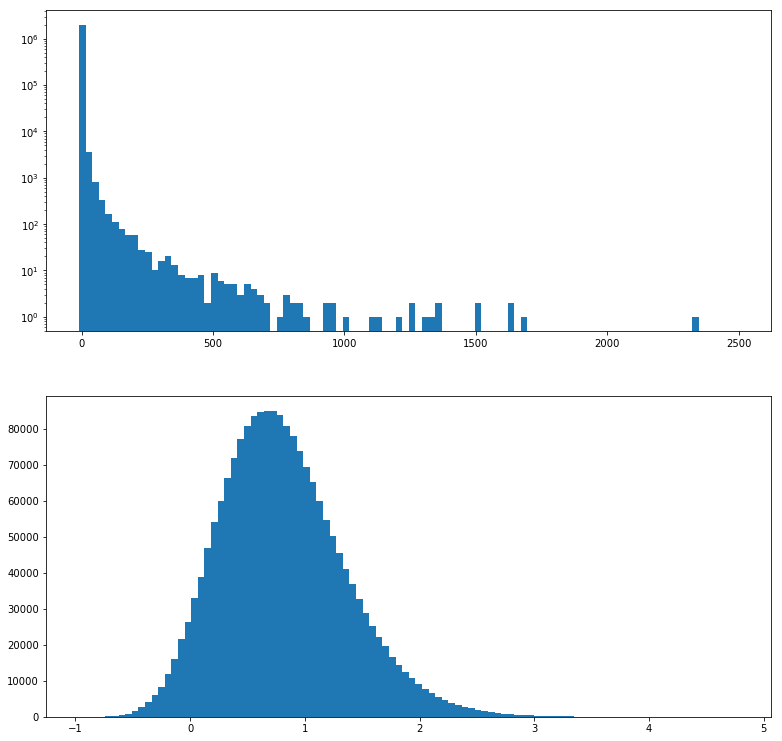

In [5]:
%%time

channel_threshold = 14   # FYI Tino uses 14

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array_konrad/simtel/astri_v2/proton/proton_20deg_180deg_run4003___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(1, 17)),
         channel_threshold=channel_threshold,
         cam_id="ASTRICam",
         max_num_samples=MAX_NUM_SAMPLES)

## Flashcam

### INAF's ASTRI mini array

FlashCam = "FlashCam" (tel 34 to 38 in prod3b - North site (LaPalma)), 1 channel

Cam ID: FlashCam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz
Tel ID range: [34, 35, 36, 37, 38]
Num samples: 2000376
Memory usage for sig_sample_array: 8.001504 Mb
Memory usage for noise2_sample_array: 15.264824 Mb
Noise: Mean = 0.01977556614946738 ; Std = 3.378251198208066
Min: -10.3921331068
Max: 27.8665886224
CPU times: user 1min 9s, sys: 531 ms, total: 1min 10s
Wall time: 1min 11s


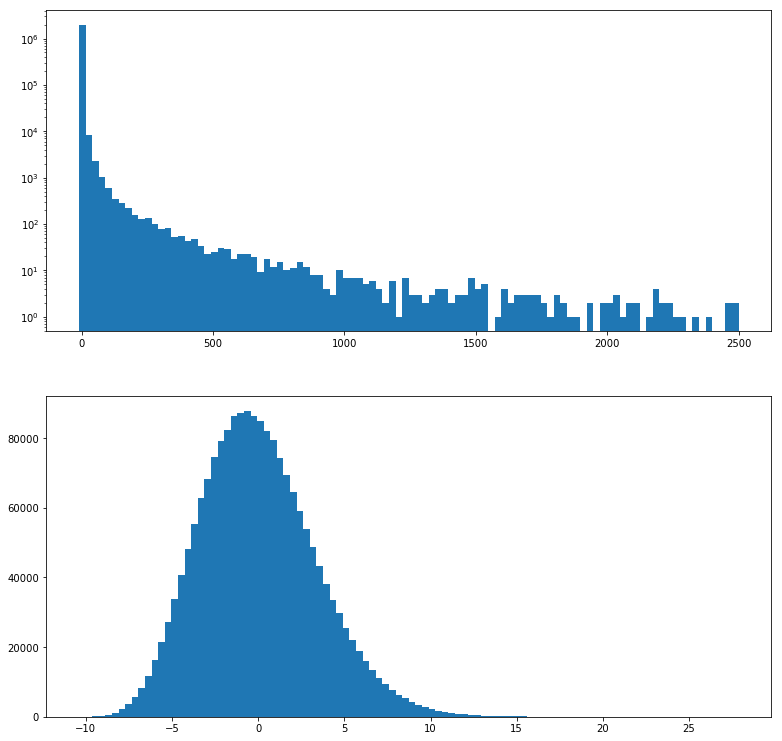

In [6]:
%%time

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/proton/run10001.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(34, 39)),
         channel_threshold=None,
         cam_id="FlashCam",
         max_num_samples=MAX_NUM_SAMPLES)

### Grid Prod3b North

FlashCam = "FlashCam" (tel 9 to 42 and 111 to 115 in prod3b - North site (LaPalma)), 1 channel

Cam ID: FlashCam
Simtel file: /Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz
Tel ID range: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 111, 112, 113, 114, 115]
Num samples: 2000376
Memory usage for sig_sample_array: 8.001504 Mb
Memory usage for noise2_sample_array: 15.53384 Mb
Noise: Mean = 0.023625967976464785 ; Std = 3.3858240881855877
Min: -10.1828348218
Max: 33.4790958002
CPU times: user 1min 12s, sys: 1.15 s, total: 1min 13s
Wall time: 1min 26s


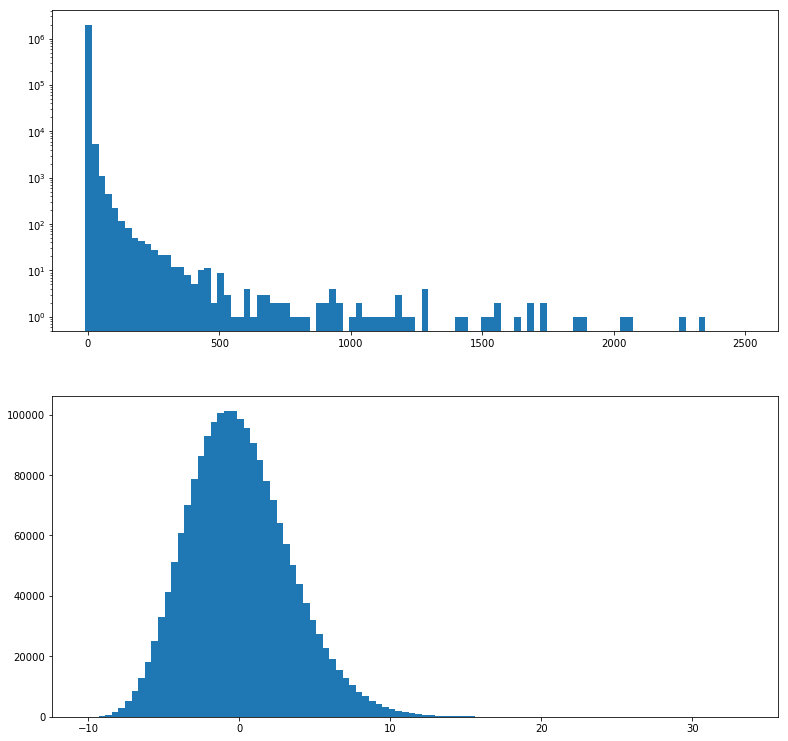

In [7]:
%%time

gamma_file_path =  "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(9, 43)) + list(range(111, 116)),
         channel_threshold=None,
         cam_id="FlashCam",
         max_num_samples=MAX_NUM_SAMPLES)

## LSTcam

### Grid Prod3b North

Dragoncam = "LSTCam" (tel 1 to 8 in prod3b - North site (LaPalma)), 2 channels

Cam ID: LSTCam
Simtel file: /Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8]
Num samples: 2001545
Memory usage for sig_sample_array: 8.00618 Mb
Memory usage for noise2_sample_array: 15.596856 Mb
Noise: Mean = 0.006735601753090293 ; Std = 1.6963708243687663
Min: -3.57007982572
Max: 27.8440180821
CPU times: user 1min 20s, sys: 2.37 s, total: 1min 23s
Wall time: 1min 31s


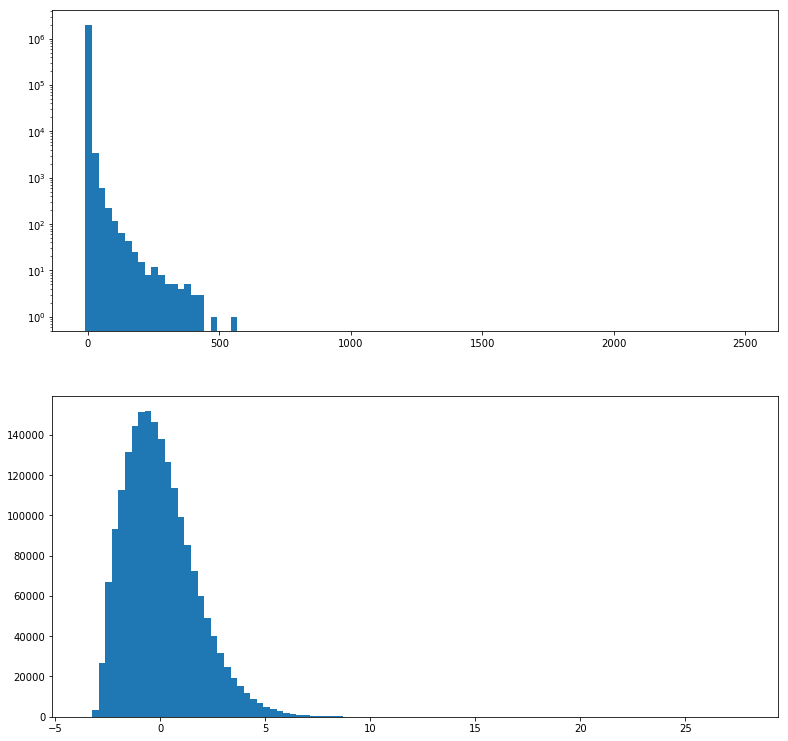

In [8]:
%%time

channel_threshold = 100

gamma_file_path =  "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(1, 9)),
         channel_threshold=channel_threshold,
         cam_id="LSTCam",
         max_num_samples=MAX_NUM_SAMPLES)

## NectarCam

### Grid Prod3b North

Nectarcam = "NectarCam" (tel 43 to 76 and 116 to 120 in prod3b - North site (LaPalma)), 2 channels

Cam ID: NectarCam
Simtel file: /Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz
Tel ID range: [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 116, 117, 118, 119, 120]
Num samples: 2001545
Memory usage for sig_sample_array: 8.00618 Mb
Memory usage for noise2_sample_array: 15.568312 Mb
Noise: Mean = 0.00381870688539652 ; Std = 1.5876763756671102
Min: -3.38060198357
Max: 25.8689892251
CPU times: user 1min 35s, sys: 7.39 s, total: 1min 43s
Wall time: 1min 54s


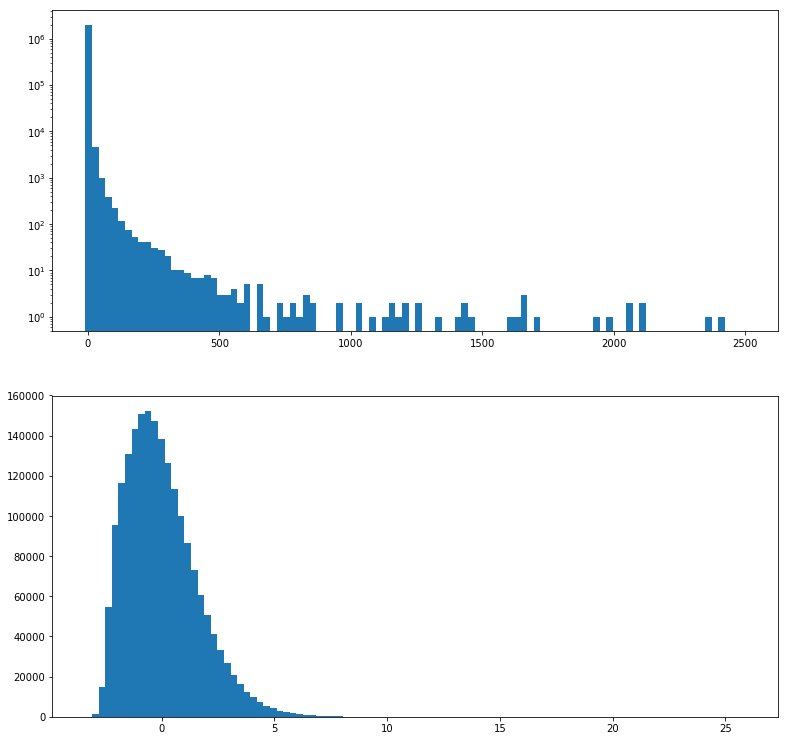

In [9]:
%%time

channel_threshold = 190

gamma_file_path =  "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run103___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(43, 77)) + list(range(116, 121)),
         channel_threshold=channel_threshold,
         cam_id="NectarCam",
         max_num_samples=MAX_NUM_SAMPLES)